# Introduction

While Deep Learning often utilizes processes in the frequency domain, there are still many relevant features to be leveraged within the time domain that are relevant to many Machine Learning techniques. Simply put, these features can be extracted and analyzed to understand the wave form's properties. When extracting features within the time-domain, we will generally study the amplitude of each sample. How we manipulate the amplitude gives us certain details about the signal in question. 

Before beginning I would like to establish some notation:

- $s(k)$ refers to the Amplitdue of the $k^{th}$ sample.
- $K$ is the frame size, or the number of samples within each frame.
- $t$ represents the frame number.

Within these examples, I will elaborate on what the feature is, how to formally define it, and show how to extract the features in Python. In the previous examples, we looked at certain sounds of instruments. However, in this example, we will look at random 7 second snippets of songs across different genres (specifically R&B, Rap, and Rock) as we will be able to better see the properties of these features.

For copyright purposes, I will not be able to share the songs in question, however I will share the output plots as well as the genre of the songs. This will allow us to study nuances between genres.

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
import librosa
import librosa.display as ld
# Load in the songs
rb, sr = librosa.load('td/rb.wav')
rap, _ = librosa.load('td/rb.wav')
rock, _ = librosa.load('td/rock.wav')

# Amplitude Envelope

The Amplitude Envelope (AE) aims to extract the maximum amplitude within each frame and string them all together. It is important to remember that the amplitude represents the volume (or loudness) of the signal. First, we split up the signal into its constituent windows and find the maximum amplitude within each window. From there, we plot the maximum amplitude in each window along time. 

We can use the AE for onset detection, or the detection of the beginning of a sound. In various speech processing applications this could be someone speaking or external noise, whereas in Music Information Retrieval (MIR) this could be the beginning of a note or instrument.

The main downfall of the AE is that is not as robust to outliers as Root-Mean-Square Energy which will we study soon.

Here is how we can formalize this concept:

$$\text{AE}_t = \max_{k = t \cdot K}^{(t+1) \cdot (K-1)} s(k) $$

Upon searching for a defined method in Python that could accomplish this task, I could not find it. Therefore, we will define it from scratch as it will be quite easy to do. The other feature extraction methods we will be looking at have already been defined in `librosa`, so we will be using those functions after formally defining them.

It is important to note that by the setup in this `for` loop, that we do not designate `hop length`. This means that when we create our upper and lower bounds, the windows do NOT overlap, making the `hop length` and the `frame length` the same.

In [30]:
def AE(signal, frame_length):
    '''
    Create the Amplitude Envelope of a given signal.
    
    Parameters:
    ------------
    
    - signal (numpy array):
        The signal/sound in question to be analyzed. 

    - frame_size (int):
        Number of samples within each frame. Formally defined as K.
    
    Returns:
    ---------
    Array of amplitude envelope
    '''
    AE = []
    # Calculate number of frames
    num_frames = math.floor(signal.shape[0] / frame_length)
    for t in range(num_frames):
        # Calculate bounds of each frame
        # By doing this, our hop length is the same as the frame length
        # Therefore, these frames are NOT overlapping.
        lower = t*frame_size
        upper = (t+1)*(frame_size-1)
        # Find maximum of each frame and add it to our array
        AE.append(np.max(signal[lower:upper]))
    return np.array(AE)

Now, to visualize and compare the AE among genres:

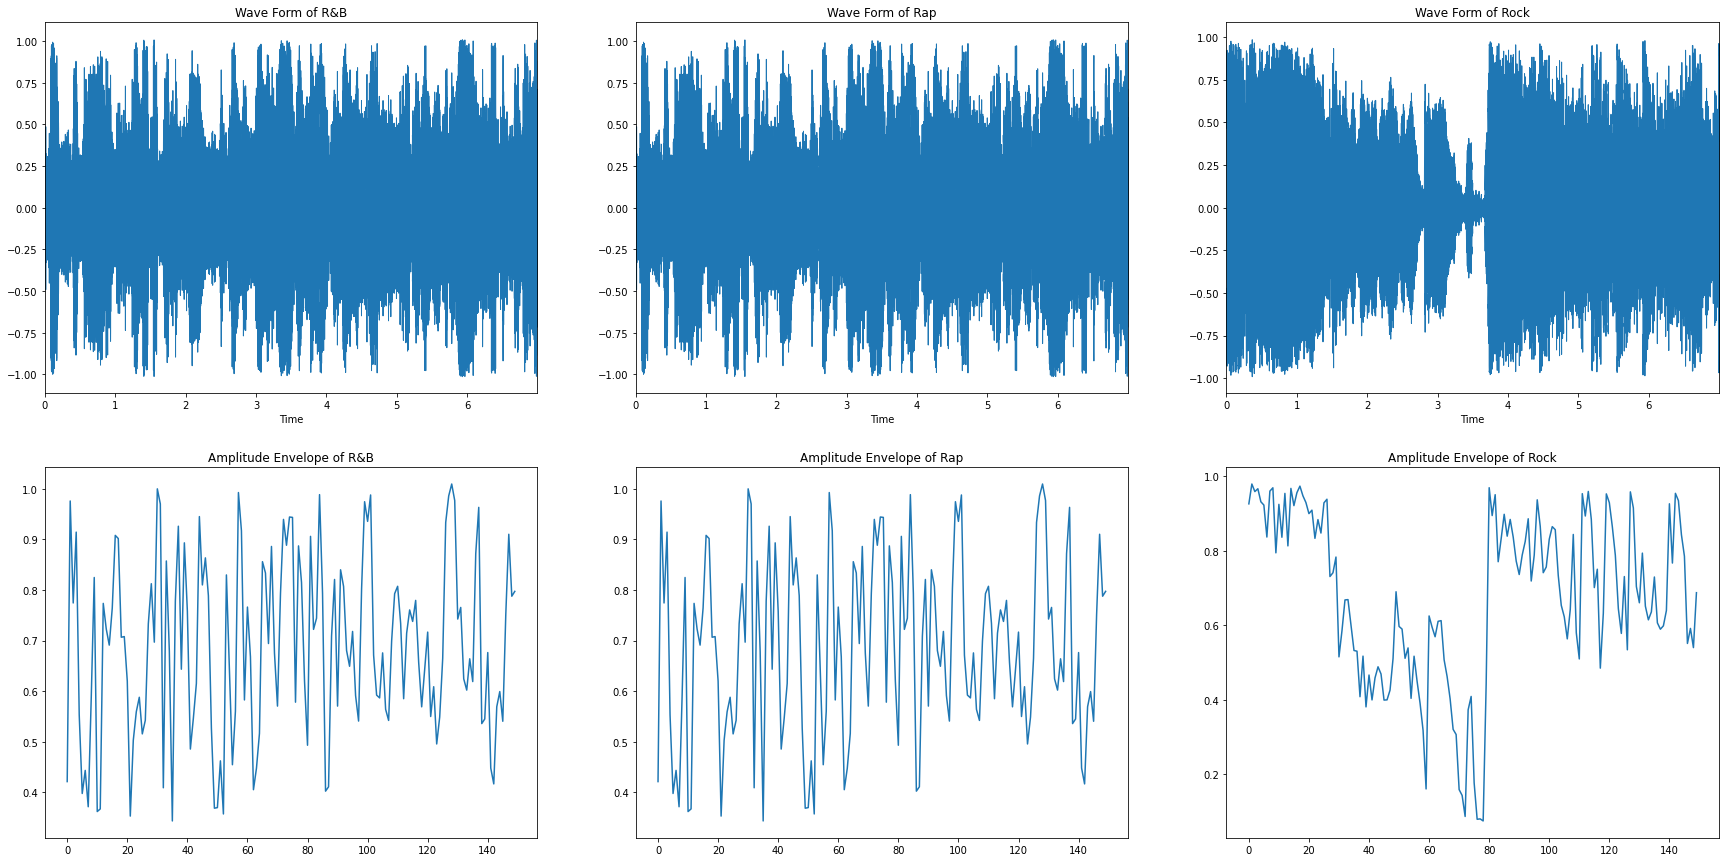

In [32]:
fig, ax = plt.subplots(2,3, figsize=(30,15))
# Plotting R&B
ax[0,0].set(title='Wave Form of R&B')
ld.waveplot(rb, sr=sr, ax=ax[0,0])
ax[1,0].set(title = 'Amplitude Envelope of R&B')
ax[1,0].plot(AE(rb, 1024))
# Plotting Rap
ax[0,1].set(title='Wave Form of Rap')
ld.waveplot(rap, sr=sr, ax=ax[0,1])
ax[1,1].set(title = 'Amplitude Envelope of Rap')
ax[1,1].plot(AE(rap, 1024))
# Plotting Rock
ax[0,2].set(title='Wave Form of Rock')
ld.waveplot(rock, sr=sr, ax=ax[0,2])
ax[1,2].set(title = 'Amplitude Envelope of Rock')
ax[1,2].plot(AE(rock, 1024))

# Root-Mean-Square Energy

As mentioned previously, the Root-Mean-Square (RMS) Energy is quite similar to the AE. As opposed to onset detection, however, it attempts to perceive loudness, which can be used for event detection. Furthermore, it is much more robust against outliers, meaning if we segment audio, we can detect new events (such a a new instrument, someone speaking, etc.) much more reliably.

The formal definition of RMS Energy:

$$\text{RMS}_t = \sqrt{\frac{1}{K} \cdot \displaystyle\sum^{(t+1) \cdot (K-1)}_{k = t \cdot K} s(k)^2}$$

If you are familiar with the concept of the Root Mean Square, this will not be too new to you. However, if you are not, do not worry.

As we window across our wave form, we square the amplitudes within the window and sum them up. Once that is complete, we will divide by the frame length, take the square root, and that will be the RMS energy of that window.

To extract the RMS, we can simply use `librosa.feature.rms`. Now, we visualize it:

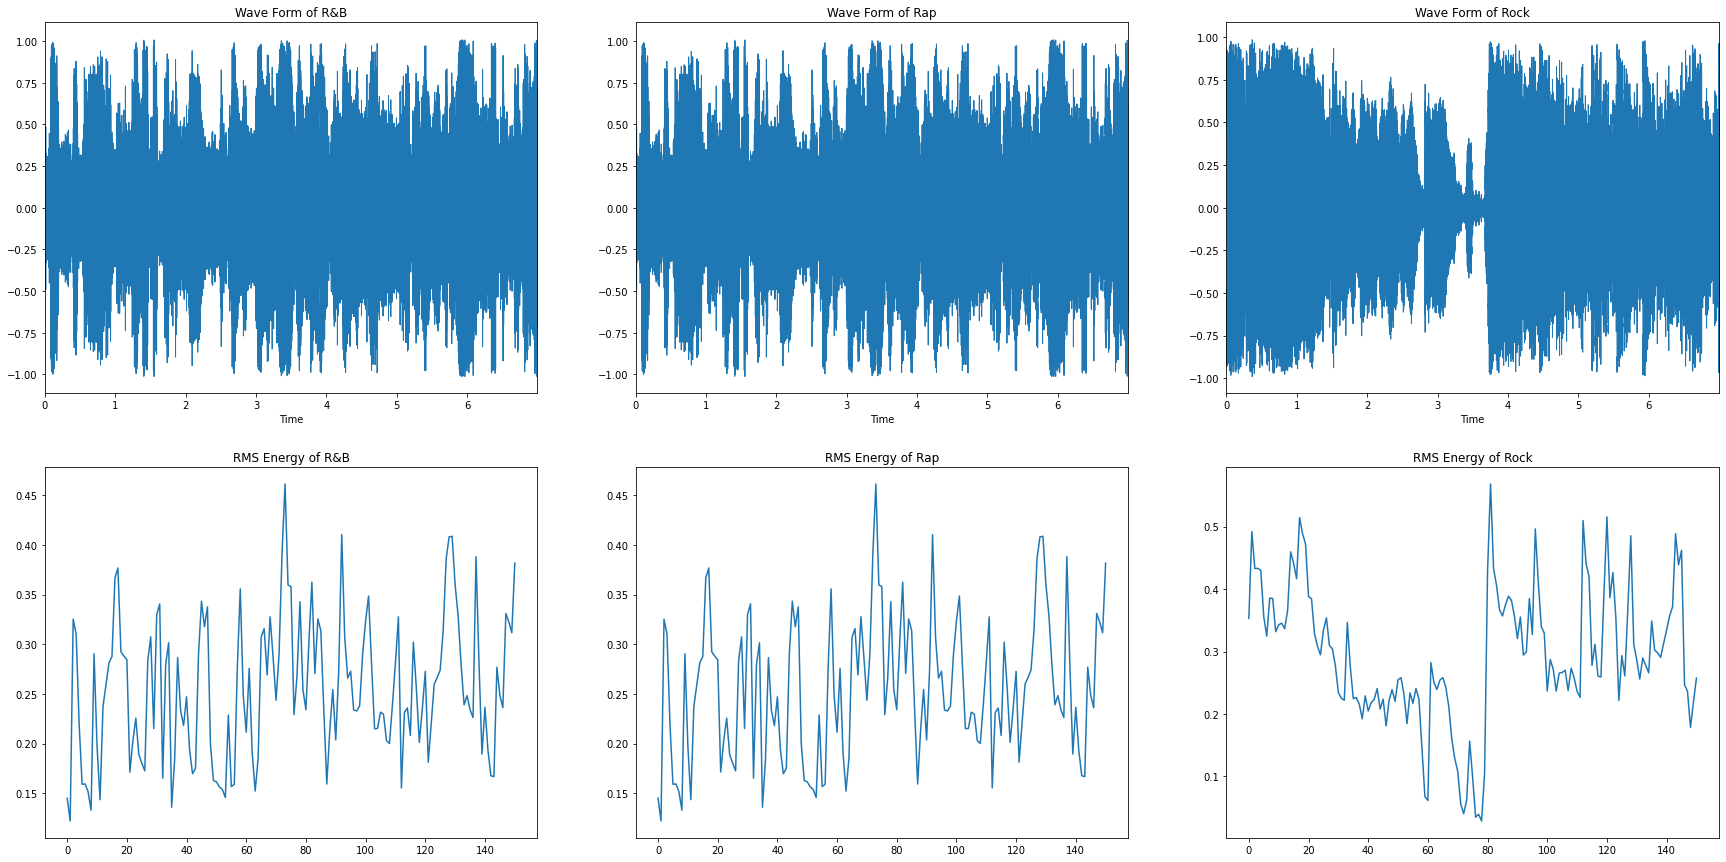

In [42]:
# Define RMS for each genre
RMSrb = librosa.feature.rms(y = rb, frame_length=1024, hop_length=1024)
RMSrap = librosa.feature.rms(y = rap, frame_length=1024, hop_length=1024)
RMSrock = librosa.feature.rms(rock, frame_length=1024, hop_length=1024)
# Now we plot:
fig, ax = plt.subplots(2,3, figsize=(30,15))
# Plotting R&B
ax[0,0].set(title='Wave Form of R&B')
ld.waveplot(rb, sr=sr, ax=ax[0,0])
ax[1,0].set(title = 'RMS Energy of R&B')
ax[1,0].plot(RMSrb.T) # Returned shape is (1,t) so we take the transpose.
# Plotting Rap
ax[0,1].set(title='Wave Form of Rap')
ld.waveplot(rap, sr=sr, ax=ax[0,1])
ax[1,1].set(title = 'RMS Energy of Rap')
ax[1,1].plot(RMSrap.T)
# Plotting Rock
ax[0,2].set(title='Wave Form of Rock')
ld.waveplot(rock, sr=sr, ax=ax[0,2])
ax[1,2].set(title = 'RMS Energy of Rock')
ax[1,2].plot(RMSrock.T)

As we can see the differences from RMS and AE, the RMS does not fluctuate as drastically as the AE. This property is what makes the RMS of the amplitude much more robust to outliers.

# Zero-Crossing Rate

The Zero-Crossing Rate (ZCR) aims to study the the rate in which a signal's amplitude changes sign within each frame. Compared to the previous two features, this one is quite simple to extract.

The formal definition of ZCR is the following:

$$\text{ZCR}_t = \frac{1}{2} \cdot \displaystyle\sum^{(t+1) \cdot (K-1)}_{k = t \cdot K} \lvert \text{sgn}(s(k)) - \text{sgn}(s(k+1)) \rvert $$

For MIR, this feature is relevant for identifying percussion sound as they often have fluctuating signals that can ZCR can detect quite well as well as pitch detection. However, this feature is generally used as a feature in speech recognition for voice activity detection.

Using `librosa`, we can extract the ZCR using `librosa.feature.zero_crossing_rate`.

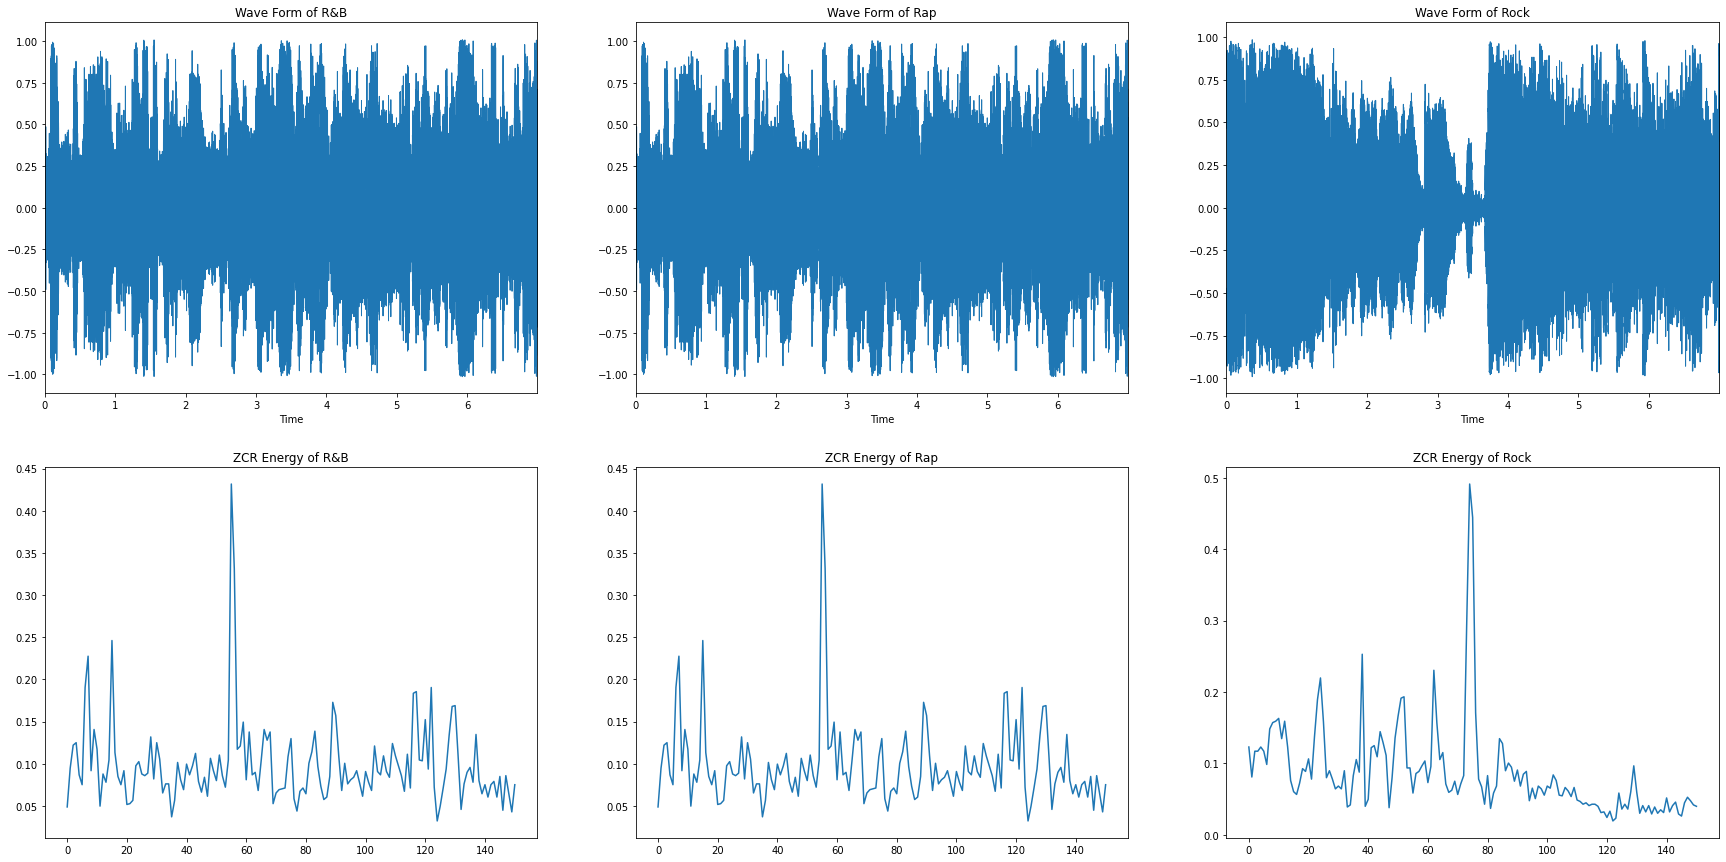

In [43]:
# Define ZCR for each genre
ZCRrb = librosa.feature.zero_crossing_rate(y = rb, frame_length=1024, hop_length=1024)
ZCRrap = librosa.feature.zero_crossing_rate(y = rap, frame_length=1024, hop_length=1024)
ZCRrock = librosa.feature.zero_crossing_rate(rock, frame_length=1024, hop_length=1024)
# Now we plot:
fig, ax = plt.subplots(2,3, figsize=(30,15))
# Plotting R&B
ax[0,0].set(title='Wave Form of R&B')
ld.waveplot(rb, sr=sr, ax=ax[0,0])
ax[1,0].set(title = 'ZCR Energy of R&B')
ax[1,0].plot(ZCRrb.T) # Returned shape is (1,t) so we take the transpose.
# Plotting Rap
ax[0,1].set(title='Wave Form of Rap')
ld.waveplot(rap, sr=sr, ax=ax[0,1])
ax[1,1].set(title = 'ZCR Energy of Rap')
ax[1,1].plot(ZCRrap.T)
# Plotting Rock
ax[0,2].set(title='Wave Form of Rock')
ld.waveplot(rock, sr=sr, ax=ax[0,2])
ax[1,2].set(title = 'ZCR Energy of Rock')
ax[1,2].plot(ZCRrock.T)

# Conclusion

By now, you should have an idea of how time feature extraction works, how it can be utilized in various audio based applications, and how to develop the feature extraction methods yourself. By leveraging the amplitude within specific windows, we open up numerous insights into various applications in MIR and ASR.